In [1]:
import getfem as gf

In [2]:
mo1 = gf.MesherObject("rectangle", [0.0, 0.0], [100.0, 300.0])

In [3]:
mo2 = gf.MesherObject("ball", [0.0, 0.0], 30.0)

In [4]:
mo = gf.MesherObject("set minus", mo1, mo2)

In [5]:
h = 5
mesh = gf.Mesh("generate", mo, h, 2)

In [6]:
fb1 = mesh.outer_faces_with_direction([ 1.0, 0.0], 0.01)
fb2 = mesh.outer_faces_with_direction([-1.0, 0.0], 0.01)
fb3 = mesh.outer_faces_with_direction([ 0.0, 1.0], 0.01)
fb4 = mesh.outer_faces_with_direction([ 0.0,-1.0], 0.01)

In [7]:
RIGHT_BOUND = 1
LEFT_BOUND = 2
TOP_BOUND = 3
BOTTOM_BOUND = 4

mesh.set_region(RIGHT_BOUND, fb1)
mesh.set_region(LEFT_BOUND, fb2)
mesh.set_region(TOP_BOUND, fb3)
mesh.set_region(BOTTOM_BOUND, fb4)

In [8]:
sl = gf.Slice(("none",), mesh, 1)

In [9]:
sl.export_to_vtk("sl.vtk", "ascii")

In [10]:
import meshio

reader = meshio.read("sl.vtk")
points = reader.points
cells = reader.cells[0][1]

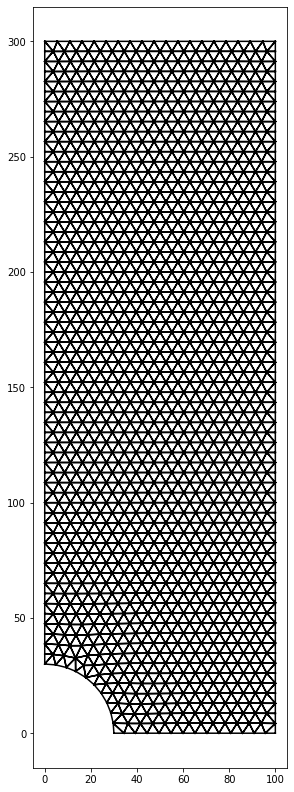

In [11]:
%matplotlib inline
from matplotlib.pyplot import figure

figure = figure(figsize=(14, 14))
axes = figure.add_subplot(aspect="equal")
axes.triplot(points[:, 0], points[:, 1], cells, color="black")

In [12]:
elements_degree = 2

mfu = gf.MeshFem(mesh, 2)
mfu.set_classical_fem(elements_degree)

mim = gf.MeshIm(mesh, elements_degree*2)

In [13]:
md = gf.Model("real")

In [14]:
md.add_fem_variable("u", mfu)

In [15]:
E = 205 # GPa
nu = 0.3

In [16]:
md.add_initialized_data("E", [E])
md.add_initialized_data("nu", [nu])

In [17]:
ind1 = md.add_isotropic_linearized_elasticity_brick_pstress(mim, "u", "E", "nu")

In [18]:
md.add_initialized_data("H1", [[1.0, 0.0], [0.0, 0.0]])
md.add_initialized_data("H2", [[0.0, 0.0], [0.0, 1.0]])
md.add_initialized_data("r", [0.0, 0.0])

In [19]:
ind2 = md.add_generalized_Dirichlet_condition_with_multipliers(mim, "u", 1.0, LEFT_BOUND, "r", "H1")
ind3 = md.add_generalized_Dirichlet_condition_with_multipliers(mim, "u", 1.0, BOTTOM_BOUND, "r", "H2")

In [20]:
F = [0.0, 1.0] # GPa
md.add_initialized_data("F", F);
ind4 = md.add_source_term_brick(mim, "u", "F", TOP_BOUND)

In [21]:
md.solve()

(0, 1)